In [1]:
## importing packages
import torch
import os
import sys
import joypy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

## exposing path 
sys.path.insert(0, "../")

from int_filt.experiments import create_experiment
from int_filt.utils.config import configuration
from int_filt.utils.utils import ensure_reproducibility

In [2]:
## globals
ACTIVATIONS = {
    "relu": torch.nn.ReLU()
}

OPTIMIZERS = {
    "adam": torch.optim.Adam,
    "adam-w": torch.optim.AdamW
}

SCHEDULERS = {
    "none": None
}

DEVICES = {
    "cpu": torch.device("cpu"),
    "cuda": torch.device("cuda")
}

## defining settings
num_dims = 1
b_net_amortized = True
sigma_x = 1e-2
sigma_y = 1e-2

## plotting
num_observations_to_plot = 1000
num_iters_to_plot = 200

Exponential non linearity

{'interpolant_method': 'pffp_v0', 'num_samples': 100, 'backbone': 'mlp', 'b_net_hidden_dims': [16], 'b_net_activation': ReLU(), 'b_net_activate_final': False, 'b_net_amortized': True, 'experiment': 'nlg', 'sigma_x': 0.01, 'sigma_y': 0.01, 'beta': 1.0, 'num_dims': 1, 'num_sims': 10000, 'num_iters': 50000, 'non_linearity': 'exp', 'step_size': 0.01, 'log_dir': './out/2024-06-12/run_2024-06-12_01-03-37', 'dump_dir': 'exp/2024-06-12/run_2024-06-12_01-03-37', 'b_net_num_grad_steps': 250, 'b_net_optimizer': 'adam-w', 'b_net_scheduler': 'none', 'b_net_lr': 0.001, 'random_seed': 128, 'device': device(type='cuda'), 'mc_config': {'num_samples': 100}}


100%|██████████| 49999/49999 [00:08<00:00, 5868.21it/s]


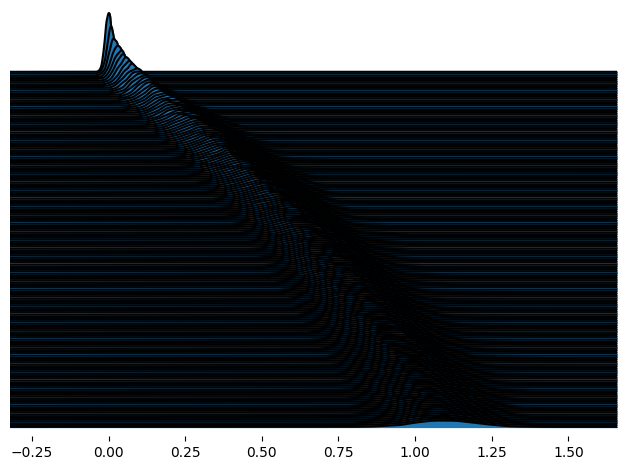

In [5]:
## defining configurations
experiment_conf = {
    "experiment": "nlg",
    "non_linearity": "exp",
    "num_dims": num_dims,
    "b_net_amortized": b_net_amortized,
    "sigma_x": sigma_x,
    "sigma_y": sigma_y
}
## parsing default arguments
args = configuration(args=[])
## retrieving activations
args.b_net_activation = ACTIVATIONS[args.b_net_activation]
## retrieving device
args.device = DEVICES[args.device]
## creating experiment
args = vars(args)

## setting current configurations
for k, v in experiment_conf.items():
    args[k] = v

## adding mc configuration
args["mc_config"] = {"num_samples": args["num_samples"]}

## prepare for training drift
b_net_num_grad_step = args["b_net_num_grad_steps"]
b_net_optimizer = args["b_net_optimizer"]
b_net_scheduler = args["b_net_scheduler"]
b_net_lr = args["b_net_lr"]

## dump dir 
dump_dir = args["dump_dir"]
path = Path(dump_dir)
path.mkdir(parents=True, exist_ok=True)

## reproducibility
random_seed = args["random_seed"]
ensure_reproducibility(random_seed)

## displaying current arguments
print(args)

## creating experiment
experiment_nlg_exp = create_experiment(args)

## joyplot
## retrieving data
latent_states_nlg_exp = torch.squeeze(experiment_nlg_exp.ssm.sim["latent_states"]).numpy().T
observations_nlg_exp = torch.squeeze(experiment_nlg_exp.ssm.sim["latent_states"]).numpy().T
## constructing data frame
#observation_indices = np.arange(args["num_iters"])
observation_indices = np.arange(num_iters_to_plot)
latent_states_nlg_exp = pd.DataFrame(latent_states_nlg_exp[:num_observations_to_plot, :num_iters_to_plot], columns = observation_indices)
## ridge plot
fig, axes = joypy.joyplot(latent_states_nlg_exp, ylabels=False)

In [6]:
## initializing optimizer
b_net_optimizer = OPTIMIZERS[b_net_optimizer](experiment_nlg_exp.b_net.backbone.parameters(), lr = b_net_lr)

## constructing optimization config dictionary
b_net_optim_config = {
    "num_grad_steps": b_net_num_grad_step,
    "optimizer": b_net_optimizer,
    "scheduler": b_net_scheduler
}

## training b_net 
experiment_nlg_exp.train(b_net_optim_config)
## saving the weights
torch.save(experiment_nlg_exp.b_net.state_dict(), os.path.join(dump_dir, "b_net_exp.pt"))

Grad step: 0, Velocity Field MSE Loss: 11.426286697387695
Grad step: 5, Velocity Field MSE Loss: 11.156567573547363
Grad step: 10, Velocity Field MSE Loss: 11.037060737609863
Grad step: 15, Velocity Field MSE Loss: 10.956230163574219
Grad step: 20, Velocity Field MSE Loss: 10.94946002960205
Grad step: 25, Velocity Field MSE Loss: 10.932168960571289
Grad step: 30, Velocity Field MSE Loss: 10.839601516723633
Grad step: 35, Velocity Field MSE Loss: 10.912629127502441
Grad step: 40, Velocity Field MSE Loss: 10.912618637084961
Grad step: 45, Velocity Field MSE Loss: 10.980607986450195
Grad step: 50, Velocity Field MSE Loss: 10.893630981445312
Grad step: 55, Velocity Field MSE Loss: 10.855619430541992
Grad step: 60, Velocity Field MSE Loss: 10.869399070739746
Grad step: 65, Velocity Field MSE Loss: 10.857954025268555
Grad step: 70, Velocity Field MSE Loss: 10.831671714782715
Grad step: 75, Velocity Field MSE Loss: 10.83996295928955
Grad step: 80, Velocity Field MSE Loss: 10.82258129119873
Gr